<a href="https://colab.research.google.com/github/omarkhater/image_classifier-application/blob/main/Copy_of_Project_Image_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> AI Image Classifier Application </center>

## Table of contents 

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#Prepare">Preparing the data</a></li>
    - <a href="#load">Loading the data </a><br>
    - <a href="#exp">Exploring the data </a><br>
    - <a href="#map">Label Mapping </a><br>
    - <a href="#pip">Creating pipeline </a><br>
    
<li><a href="#Build">Build and Train the Classifier</a></li>
    - <a href="#Test">Testing the Network </a><br>
    - <a href="#Save">Saving the model </a><br>
    - <a href="#Load">Loading the model </a><br>

 
<li><a href="#Inf_class">Inference for Classification</a></li>
    - <a href="#pre"> Image Pre-processing </a><br>
    - <a href="#Inf"> Inference</a><br>
    - <a href="#San"> Sanity Check</a><br>
 
</ul>

<a id = 'intro'></a>
## Introduction 

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, we'll train an image classifier to recognize different species of flowers. One can imagine using something like this in a phone app that able to recgonize the name of the flower in front of the camera. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='https://github.com/omarkhater/image_classifier-application/blob/main/assets/Flowers.png?raw=1' width=500px>

This project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use the trained model to perform inference on flower images.

#### Import Resources

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import json
import tensorflow_hub as hub
import time
import numpy as np

#### Control the notebook

In [2]:
train = True
save = True
load = False

<a id = 'Prepare'></a>
## Preparing the data 

<a id = 'load'></a>
### Loading the Dataset

Here we'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  We'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

In [3]:
# Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised = True, with_info = True)

In [4]:
training_set, validation_set, test_set = dataset['train'], dataset['validation'], dataset['test']

<a id = 'exp'></a>
### Exploring the Dataset

In [5]:
# Get the number of classes in the dataset from the dataset info.
num_classes = dataset_info.features['label'].num_classes
# Print important info 
print('\u2022 There are {:,} images in the training set'.format(len(training_set)))
print('\u2022 There are {:,} images in the validation set'.format(len(validation_set)))
print('\u2022 There are {:,} images in the test set'.format(len(test_set)))
print('\u2022 There are {:,} different classes in the dataset'.format(num_classes))

• There are 1,020 images in the training set
• There are 1,020 images in the validation set
• There are 6,149 images in the test set
• There are 102 different classes in the dataset


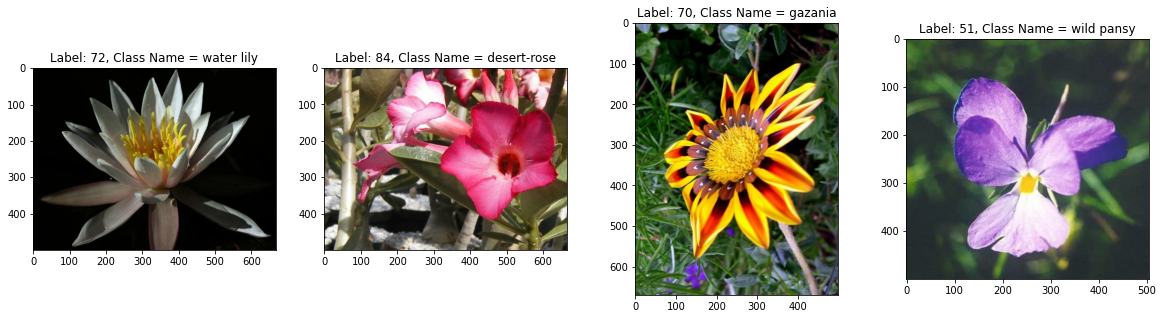

In [6]:
# Print some images from the training set.
Names = dataset_info.features['label'].names
num_images = 4
i = 0
fig,ax = plt.subplots(1,num_images, figsize=(5*num_images, 5))

for image, label in training_set.take(num_images):
    image = image.numpy()
    label = label.numpy()
    ax[i].imshow(image)
    ax[i].set_title('Label: {}, Class Name = {}'.format(label,Names[label]))
    i+=1

<a id = 'map'></a>
### Label Mapping

We need to load in a mapping from label to category name which can be found in the file `label_map.json`. It's a JSON object which gives a dictionary mapping the integer coded labels to the actual names of the flowers.

In [7]:
with open('/content/label_map.json', 'r') as f:
    class_names = json.load(f)

In [8]:
len(list(class_names.keys()))

102

<a id = 'pip'></a>
### Create Pipeline

In [9]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    image = tf.image.resize_with_crop_or_pad(image, target_height = image_size, target_width = image_size)
    return image, label

def augment_data(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, 0.4, 1.0)
    image = tf.image.rot90(image)
      # Add more augmentation of your choice
    return image, label

image_size = 224
batch_size = 32
num_training_examples = len(training_set)
training_batches = training_set.cache().shuffle(num_training_examples//4).padded_batch(batch_size).map(normalize).map(augment_data).prefetch(1)
validation_batches = validation_set.cache().padded_batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().padded_batch(batch_size).map(normalize).prefetch(1)

In [10]:
X_train = list(map(lambda x: x[0], training_set))
y_train = list(map(lambda x: x[1], training_set))

<a id = 'Build'></a>
## Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. We would use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Then, we build and train a new feed-forward classifier using those features.

To accomplish this goal, we do the following:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save the trained model as a Keras model. 

In [11]:
# Load MobileNet pre-trained model from TensorFlow Hub.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size,3))
# Preserve trained parameters
feature_extractor.trainable = False
# Build the model 
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
EPOCHS = 100
if train:
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                  filepath='BestClassifier.h5',
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=True)
    history = model.fit(training_batches,
                        epochs = EPOCHS,
                        validation_data=validation_batches,
                        callbacks = model_checkpoint_callback)


Epoch 1/100
32/32 [==============================] - 24s 568ms/step - loss: 5.1197 - accuracy: 0.0218 - val_loss: 3.9581 - val_accuracy: 0.1284
Epoch 2/100
32/32 [==============================] - 15s 486ms/step - loss: 3.3481 - accuracy: 0.2602 - val_loss: 3.1997 - val_accuracy: 0.2696
Epoch 3/100
32/32 [==============================] - 15s 489ms/step - loss: 2.4109 - accuracy: 0.4988 - val_loss: 2.7391 - val_accuracy: 0.3814
Epoch 4/100
32/32 [==============================] - 16s 491ms/step - loss: 1.9178 - accuracy: 0.6117 - val_loss: 2.4772 - val_accuracy: 0.4304
Epoch 5/100
32/32 [==============================] - 16s 492ms/step - loss: 1.3887 - accuracy: 0.7531 - val_loss: 2.3087 - val_accuracy: 0.4706
Epoch 6/100
32/32 [==============================] - 16s 496ms/step - loss: 1.1771 - accuracy: 0.8109 - val_loss: 2.2016 - val_accuracy: 0.4686
Epoch 7/100
32/32 [==============================] - 16s 496ms/step - loss: 1.0891 - accuracy: 0.8124 - val_loss: 2.1277 - val_accuracy:

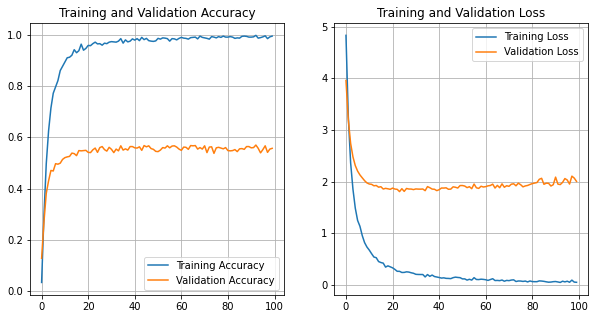

In [13]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()


<a id = 'Test'></a>
### Testing the Network

It's a good practice to test the trained network on the test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images.

In [14]:
# Print the loss and accuracy values achieved on the entire test set.
if train:
    loss, accuracy = model.evaluate(testing_batches)

193/193 [==============================] - 47s 241ms/step - loss: 2.2951 - accuracy: 0.5081


<a id = 'Save'></a>
### Save the Model

Now that the network is trained, we save the model so we can load it later for making inference.

In [15]:
# Save the trained model as a Keras model.
if save:
    name = 'Classifier'
    saved_keras_model_filepath = './{}.h5'.format(name)
    model.save(saved_keras_model_filepath)

<a id = 'Load'></a>
### Load the Keras Model
If we already trained and saved the model, we can load it easily using

In [16]:
# Load the Keras model
if load:
    reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={'KerasLayer':hub.KerasLayer})
    reloaded_keras_model.summary()

<a id = 'Inf_class'></a>
## Inference for Classification

Now we'll write a function that uses the trained network for inference which takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. 

<a id = 'pre'></a>
### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

In [17]:
# Create the process_image function
def process_image(image):
    imten = tf.convert_to_tensor(image)
    imten = tf.image.resize(imten, (image_size,image_size))
    imten = tf.cast(imten, tf.float32)
    imten /= 255
    return imten.numpy()

To check the `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by the `process_image` function. 

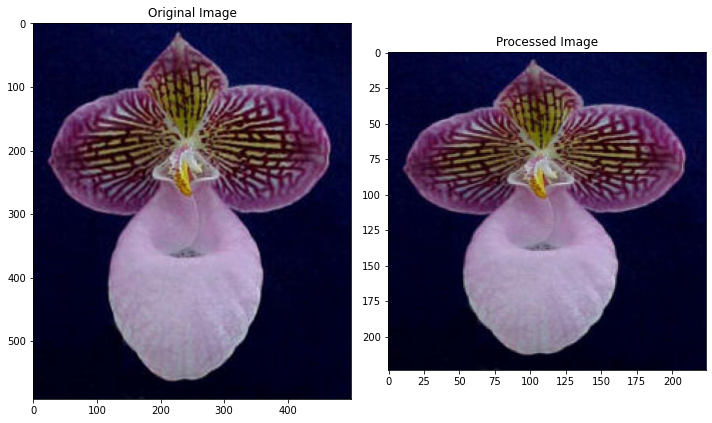

In [18]:
from PIL import Image

image_path = '/content/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

<a id = 'Inf'></a>
### Inference

Once we can get the images in the correct format, it's time to write the `predict` function for making inference with your model.

In [24]:
def predict(image_path , model , top_k):
    im = Image.open(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    all_probs =  model.predict(np.expand_dims(processed_test_image, axis = 0))
    all_classes = np.argsort(all_probs)
    probs = all_probs[:,all_classes[:,-top_k:]]
    classes = all_classes[:,-top_k:]
    return probs[0][0], classes[0]

<a id = 'San'></a>
### Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='https://github.com/omarkhater/image_classifier-application/blob/main/assets/inference_example.png?raw=1' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [25]:
probs, classes = predict(image_path, model, 5 )

In [26]:
test_images = ['cautleya_spicata.jpg', 'hard-leaved_pocket_orchid.jpg', 'orange_dahlia.jpg','wild_pansy.jpg']

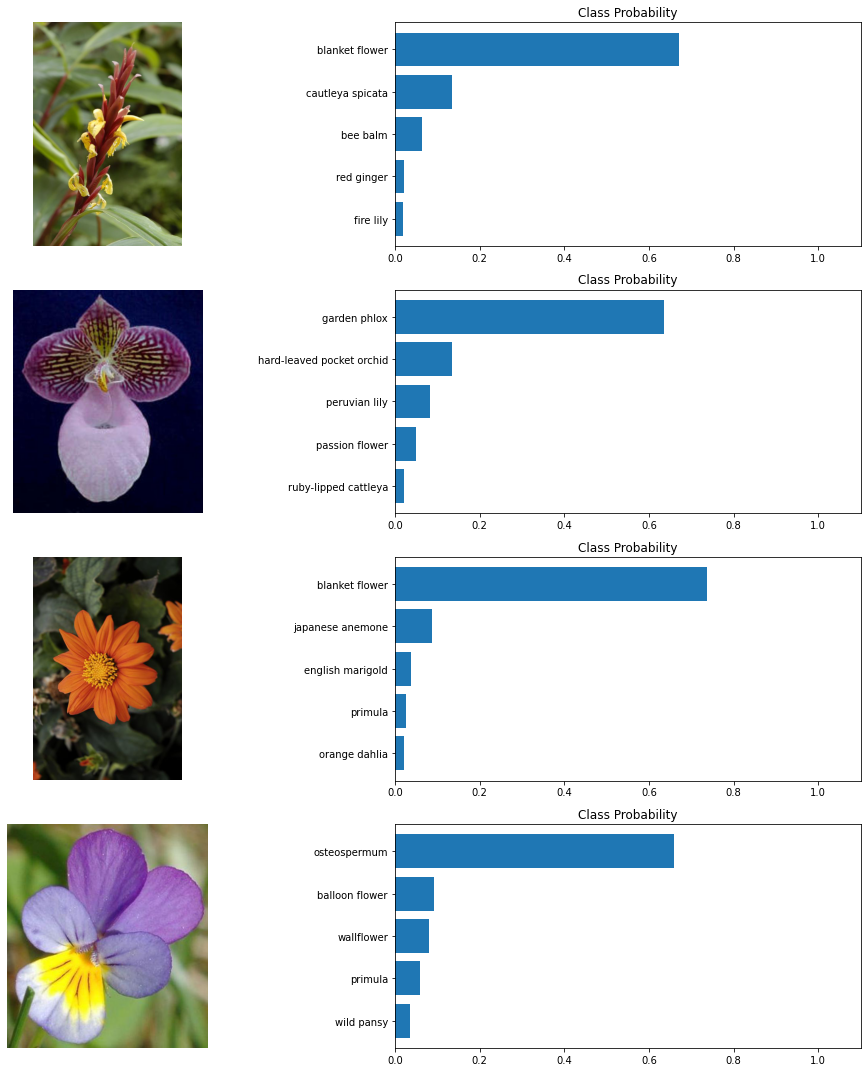

In [29]:
fig, ax = plt.subplots(figsize=(15,15), nrows = len(test_images), ncols=2)
i = 0
for imagepath in test_images:
    probs, classes = predict('/content/' + imagepath, model, 5 )
    ax[i][0].imshow(Image.open('/content/' + imagepath), cmap = plt.cm.binary)
    ax[i][0].axis('off')
    ax[i][1].barh([class_names[str(i+1)] for i in classes], probs)
    ax[i][1].set_aspect(0.1)
    ax[i][1].set_yticks(np.arange(5))
    ax[i][1].set_title('Class Probability')
    ax[i][1].set_xlim(0, 1.1)
    plt.tight_layout()
    i+= 1